In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot forecast maps with all available models.
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools
import numpy as np
import timeit
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import xesmf as xe
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import calendar

from esio import EsioData as ed
from esio import ice_plot
from esio import import_data


import dask
from dask.distributed import Client


# General plotting settings
sns.set_style('ticks')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

In [2]:
def get_plot_title(cmod, custom_names, E):
    if cmod in custom_names:
        new_title = custom_names[cmod]
    elif cmod in E.model.keys():
        new_title = E.model[cmod]['model_label']
    else:
        new_title = cmod
    return new_title

In [3]:
def add_subplot_title(cmod, custom_names, E, ax=None):

    ax.set_title(get_plot_title(cmod, custom_names, E))

In [4]:
E = ed.EsioData.load()
# Directories
all_models=['rasmesrl']
runType='forecast'


In [5]:
# Plotting Info
runType = 'forecast'
variables = ['sic']
metrics_all = {'sic':['SIP']}
# Some models not to include
MME_NO = ['hcmr']

### Time configuration

In [17]:
# Target time range
valid_start = np.datetime64('2018-09-01')
valid_end = np.datetime64('2018-09-30')

# SIO Report Year_Month
cyear = '2019'
cmonth = 'June'
# cmonth = 'July'
# cmonth = 'August'

# Models that create an Ensemble using different init days
it_target_size = {'usnavysipn':10, 'ukmetofficesipn':21} # Define the number of past days to use TODO: assumes daily inits

In [7]:
# Get recent observations
ds_81 = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'_yearly/*.nc', concat_dim='time', autoclose=True, parallel=True)

In [8]:
# Define custom mod names
custom_names = {'usnavysipn':'NESM','gfdlsipn':'GFDL/NOAA','noaasipn':'NCEP CPC','uclsipn':'UCL',
                'ukmetofficesipn':'Met Office','ecmwfsipn':'ECMWF-c3s',
               'nicosipn':'Nico Sun','awispin':'AWI\n(Kauker et al.)','szapirosipn':'MPAS-CESM'}

In [9]:
# Define models to plot
No_No_models = ['MME_NEW','piomas','MME','modcansipns_3','modcansipns_4','ecmwfsipn','usnavygofs']
non_SIPN_Report_models  = ['ecmwf','ukmo','kma','ncep','usnavyncep','metreofr','dampedAnomalyTrend'] # Models like s2s
models_2_plot = list(E.model.keys())
models_2_plot = [x for x in models_2_plot if np.any(x not in No_No_models) ] # remove some models
models_2_plot = [x for x in models_2_plot if np.any(x not in non_SIPN_Report_models) ] # remove some more models
models_2_plot = [x for x in models_2_plot if E.icePredicted[x]] # Only predictive models
models_2_plot

['gfdlsipn',
 'yopp',
 'ukmetofficesipn',
 'usnavysipn',
 'rasmesrl',
 'noaasipn',
 'noaasipn_ext',
 'uclsipn',
 'szapirosipn',
 'awispin',
 'nicosipn',
 'fgoalssipn']

In [10]:
stero_grid_file = E.obs['NSIDC_0051']['grid']
obs_grid = import_data.load_grid_info(stero_grid_file, model='NSIDC')
# Ensure latitude is within bounds (-90 to 90)
# Have to do this because grid file has 90.000001
obs_grid['lat_b'] = obs_grid.lat_b.where(obs_grid.lat_b < 90, other = 90)
# Load in regional data
ds_region = xr.open_dataset(os.path.join(E.grid_dir, 'sio_2016_mask_Update.nc'))

In [18]:
# Load in last results
ds_SIP_All = xr.open_mfdataset('/home/disk/sipn/nicway/data/model/SIO/'+cyear+'/'+cmonth+'/SIP.nc').SIP
cvar = 'sic'
metric = 'SIP'

In [19]:
ds_SIP_All

<xarray.DataArray 'SIP' (model: 12, x: 304, y: 448)>
dask.array<shape=(12, 304, 448), dtype=float64, chunksize=(12, 304, 448)>
Coordinates:
    lon        (x, y) float64 dask.array<shape=(304, 448), chunksize=(304, 448)>
    lat        (x, y) float64 dask.array<shape=(304, 448), chunksize=(304, 448)>
  * model      (model) object 'gfdlsipn' 'ukmetofficesipn' ... 'nicosipn'
    init_date  (model) datetime64[ns] dask.array<shape=(12,), chunksize=(12,)>
Dimensions without coordinates: x, y

In [20]:
# # Damped persistence trend has slightly different lat long (10^-6) so use lat lon from any other model here
# print("hack for bad lat lon in peristence, fix upstream!")
# ds_SIP_All['lat'] = ds_SIP_All.lat.sel(model='gfdlsipn').drop('model')

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<Figure size 432x288 with 0 Axes>

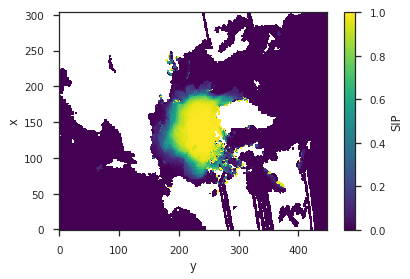

<Figure size 432x288 with 0 Axes>

In [33]:
ds_MME_avg.plot()
plt.figure()

In [21]:
ds_MME_avg = ds_SIP_All.mean(dim='model')
ds_MME_std = ds_SIP_All.std(dim='model')

In [22]:
fig_dir='/home/disk/sipn/bitz/figures/'

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


saved  /home/disk/sipn/bitz/figures/panArctic_SIP_forecast_2019_June_lowRES.png


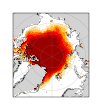

In [36]:
cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"], N=10)
#cmap_c = plt.get_cmap('jet') 
cmap_c.set_bad(color = 'lightgrey')
c_label = 'Sea Ice Probability (-)'
c_vmin = 0
c_vmax = 1

# New Plot
central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1
(f, axes) = ice_plot.multi_polar_axis(ncols=2, nrows=1, Nplots=2, extent=central_extent, central_longitude=0)


# MME Mean
i = 0

pmme = ds_MME_avg.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
axes[i].set_title('')


f.subplots_adjust(bottom=0.05)

# Save to file
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'.png')
f.savefig(f_out,bbox_inches='tight', dpi=600)
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'_lowRES.png')
f.savefig(f_out,bbox_inches='tight', dpi=90)
print("saved ", f_out)



In [ ]:
# Need to add check -- Compare June to July models (Make sure they are different! (unless they are supposed to be unchanged))